In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
diabetes = pd.read_csv('diabetes.csv')
print(diabetes.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [53]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### The diabetes dataset consists of 768 data points, with 9 features each

In [54]:
diabetes.shape

(768, 9)

### Outcome 0 means No diabetes, outcome 1 means diabetes
Of these 768 data points, 500 are labeled as 0 and 268 as 1:

In [55]:
print(diabetes.groupby('Outcome').size())

Outcome
0    500
1    268
dtype: int64


E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outcome', ylabel='count'>

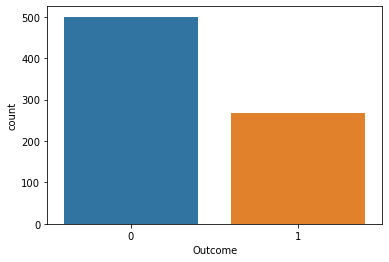

In [56]:
import seaborn as sns

sns.countplot(diabetes['Outcome'],label="Count")

In [57]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### k-Nearest Neighbors
The k-NN algorithm is arguably the simplest machine learning algorithm. Building the model consists only of storing the training dataset. To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset—its “nearest neighbors.”

### Let’s investigate whether we can confirm the connection between model complexity and accuracy

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes.loc[:, diabetes.columns != 'Outcome'], diabetes['Outcome'], stratify=diabetes['Outcome'], random_state=66)

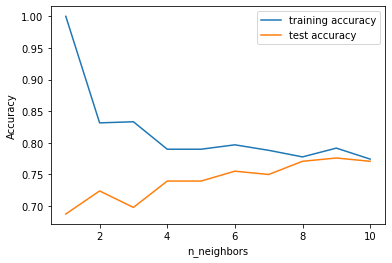

In [59]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. Considering if we choose one single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the training accuracy drops, indicating that using the single nearest neighbor leads to a model that is too complex.
The best performance is somewhere around 9 neighbors.

The above plot suggests that we should choose n_neighbors=9. Here we are:

In [60]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.79
Accuracy of K-NN classifier on test set: 0.78


### Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.714


The accuracy on the training set is 100%, while the test set accuracy is much worse. This is an indicative that the tree is  overfitting and not generalizing well to new data. Therefore, we need to apply pre-pruning to the tree.

We set max_depth=3, limiting the depth of the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set.

In [62]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.773
Accuracy on test set: 0.740


### Feature importance in Decision trees
Feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [63]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.04554275 0.6830362  0.         0.         0.         0.27142106
 0.         0.        ]


We can then visualize the feature importances.

Feature "Glucose" is by far the most important feature.

### Random Forest

let’s apply a random forest consisting of 100 trees on the diabetes dataset:

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.786


The random forest gives us an accuracy of 78.6%, better than the logistic regression model or a single decision tree, without tuning any parameters. However, we can adjust the max_features setting, to see whether the result can be improved.

In [65]:
rf1 = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
rf1.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf1.score(X_test, y_test)))

Accuracy on training set: 0.800
Accuracy on test set: 0.755


It did not, this indicates that the default parameters of the random forest work well.

### Feature importance in Random Forest

Similarly to the single decision tree, the random forest also gives a lot of importance to the “Glucose” feature, but it also chooses “BMI” to be the 2nd most informative feature overall. The randomness in building the random forest forces the algorithm to consider many possible explanations, the result being that the random forest captures a much broader picture of the data than a single tree.

### Gradient Boosting

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(X_test, y_test)))

Accuracy on training set: 0.917
Accuracy on test set: 0.792


We are likely to be overfitting. To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate:

In [67]:
gb1 = GradientBoostingClassifier(random_state=0, max_depth=1)
gb1.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb1.score(X_test, y_test)))

Accuracy on training set: 0.804
Accuracy on test set: 0.781


In [68]:
gb2 = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gb2.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb2.score(X_test, y_test)))

Accuracy on training set: 0.802
Accuracy on test set: 0.776


Both methods of decreasing the model complexity reduced the training set accuracy, as expected. In this case, none of these methods increased the generalization performance of the test set.

We can visualize the feature importances to get more insight into our model even though we are not really happy with the model.

We can see that the feature importances of the gradient boosted trees are somewhat similar to the feature importances of the random forests, it gives weight to all of the features in this case.

### Summary
We practiced a wide array of machine learning models for classification and regression, what their advantages and disadvantages are, and how to control model complexity for each of them. We saw that for many of the algorithms, setting the right parameters is important for good performance.

We should be able to know how to apply, tune, and analyze the models we practiced above.